# In this file we calibrate the Heston model through the classical FFT
Here we will use the classical pricer: the FFT in order to make a time comparison with the NN calibration. In this case the implied volatility surface is on a fixed grid 11(strikes)x8(maturities).
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/Heston/grid based")

In [2]:
#import libraries
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f) #load data in a numpy array
xx=dat[:,:5]   #extract first 5 columns (Heston parameters)
yy=dat[:,5:]   #extract last  columns ()

#define strikes and maturities
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# Print shapes with descriptive messages
print("Shape of the full dataset (samples × (parameters + implied_vols)):", dat.shape)
print("\nInput (Heston parameter sets) shape (samples × 5 parameters):", xx.shape)
print("  - Each row contains: [ν₀, ρ, γ, θ, κ]")
print("\nTarget (Implied Volatility Surfaces) shape (samples × (maturities × strikes)):", yy.shape)
print(f"  - Each row represents a {len(maturities)}×{len(strikes)} grid (maturities × strikes)")

Shape of the full dataset (samples × (parameters + implied_vols)): (12000, 93)

Input (Heston parameter sets) shape (samples × 5 parameters): (12000, 5)
  - Each row contains: [ν₀, ρ, γ, θ, κ]

Target (Implied Volatility Surfaces) shape (samples × (maturities × strikes)): (12000, 88)
  - Each row represents a 8×11 grid (maturities × strikes)


In [3]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.stats import norm

def char_exp(v, params,T):
    """
    Characteristic exponent for Heston 1993 model (B(ψ) + C(ψ))
    
    Parameters:
    - v: Fourier transform variable (can be array or scalar)
    - params: tensor containing Heston parameters:
    -T: time to maturity
    
    Returns:
    - Characteristic exponent value(s)
    """
    # Extract parameters [ν₀, ρ, γ, θ, κ]
    V0 = params[0]
    rho = params[1]
    gamma = params[2]
    theta = params[3]
    kappa = params[4]
     
    # Calculate intermediate terms
    zeta = -0.5 * (v**2 + 1j*v)  # ζ(ω)
    gamma_adj = kappa - rho * gamma * v * 1j  # γ(ω)
    psi = np.sqrt(gamma_adj**2 - 2 * gamma**2 * zeta)  # ψ(ω)
    
    # Calculate B(ψ)
    numerator_B = 2 * zeta * (1 - np.exp(-psi * T)) * V0
    denominator_B = 2 * psi - (psi - gamma_adj) * (1 - np.exp(-psi * T))
    B = numerator_B / denominator_B
    
    # Calculate C(ψ)
    log_term = np.log((2 * psi - (psi - gamma_adj) * (1 - np.exp(-psi * T))) / (2 * psi))
    C = (-2 * kappa * theta / gamma**2) * (2 * log_term + (psi - gamma_adj) * T)
    
    return B + C

def cf_Heston(v, T, r, params):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    
    Parameters:
    - v: Fourier transform variable (can be array or scalar)
    - T: time to maturity
    - r: risk-free interest rate
    - params: tensor containing Heston parameters:

    
    Returns:
    - Characteristic function value(s)
    """
    # Extract parameters [ν₀, ρ, γ, θ, κ]
    v0 = params[0]
    rho = params[1]
    gamma = params[2]
    theta = params[3]
    kappa = params[4]

    xi = kappa - gamma * rho * v * 1j
    d = np.sqrt(xi**2 + gamma**2 * (v**2 + 1j * v))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * v * r * T
        + (kappa * theta) / (gamma**2) * ((xi - d) * T - 2 * np.log((1 - g2 * np.exp(-d * T)) / (1 - g2)))
        + (v0 / gamma**2) * (xi - d) * (1 - np.exp(-d * T)) / (1 - g2 * np.exp(-d * T))
    )
    return cf


def FFT_CM_Call(Strike, params, T, r, S0):
    """
    Compute EU vanilla option prices using Carr-Madan FFT method
    
    Parameters:
    - Strike: Strike prices
    - params: Model parameters
    - T: Time to maturity
    - r: Risk-free rate
    - S0: Spot price
    
    Returns:
    - Option prices for that given maturity
    """
    # Discretization parameters
    Npow = 15
    N = 2**Npow
    A = 1200

    # Discretization step
    eta = A/N
    
    # Avoid division by zero
    v = np.arange(0, A*(N-1)/N + eta, eta)
    v[0] = 1e-22

    # Numerical parameter for log-moneyness grid
    lambda_param = 2 * np.pi / (N * eta)
    
    # Grid of log-moneyness
    k = -lambda_param * N/2 + lambda_param * np.arange(N)

    # Characteristic function
    #char_func = lambda v: np.exp(char_exp(v, params,T))
    char_func = lambda v: cf_Heston(v, T, r, params)

    # Carr-Madan argument of inverse Fourier transform
    Z_k = np.exp(1j * r * v * T) * \
          (char_func(v - 1j) - 1) / (1j * v * (1j * v + 1))

    # Trapezoidal integration weights
    w = np.ones(N)
    w[0] = 0.5
    w[-1] = 0.5

    # Compute option prices via FFT
    x = w * eta * Z_k * np.exp(1j * np.pi * np.arange(N))
    z_k = np.real(np.fft.fft(x) / np.pi)

    # Compute strikes and call prices
    K = S0 * np.exp(k)
    C = S0 * (z_k + np.maximum(1 - np.exp(k - r * T), 0))

    # Filter reasonable strikes
    index = np.where((K > 0.1 * S0) & (K < 3 * S0))[0]
    K_filtered = K[index]
    C_filtered = C[index]

    # Interpolate to get prices for given strikes
    price_interp = interp1d(K_filtered, C_filtered, kind='cubic', 
                             fill_value='extrapolate')
    
    prices = price_interp(Strike)
    return np.maximum(prices, 1e-8)  # Ensure no price is below 1e-8

# Define B&S price function 
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price
    
    Parameters:
    - S: Spot price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free rate
    - sigma: Volatility
    - option_type: 'call' or 'put'
    
    Returns:
    - Option price
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    return price

#Define function to compute IV using Brent's method
def implied_volatility(market_price, S, K, T, r, option_type='call'):
    """
    Calculate implied volatility using Brent's method
    
    Parameters:
    - market_price: Observed market price of option
    - S: Spot price
    - K: Strike price
    - T: Time to maturity
    - r: Risk-free rate
    - option_type: 'call' or 'put'
    
    Returns:
    - Implied volatility
    """
    # Define the price difference function to find root of
    def price_diff(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price
    
    # Brent's method bounds (0.0001% to 200%)
    try:
        iv = brentq(price_diff, 1e-6, 2.0, maxiter=4000)
        return  np.clip(iv, 1e-6, 2.0)
    except ValueError:
        # Handle cases where solution is not found
        return np.nan

def FFT_CM_Call_IV(Strike, params, T, r, S0):
    """
    Compute EU vanilla option implied volatilities using Carr-Madan FFT method
    
    Parameters:
    - Strike: Strike prices
    - params: Model parameters
    - T: Time to maturity
    - r: Risk-free rate
    - S0: Spot price
    
    Returns:
    - Implied volatilities for given strikes
    """
    # Get option prices using FFT implementation
    call_prices = FFT_CM_Call(Strike, params, T, r, S0)
    
    # Calculate implied volatilities
    ivs = np.zeros_like(Strike)
    for i, (strike, price) in enumerate(zip(Strike, call_prices)):
        ivs[i] = implied_volatility(price, S0, strike, T, r)
    
    return ivs

(1+2.3077343933707533e-24j)
[ 0.01142844 -0.3371968   0.86407003  0.05240613  8.4248027 ]
[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
[0.50034027 0.40168361 0.30617511 0.21785335 0.14226766 0.08401111
 0.0452421  0.02227477 0.01027804 0.00455604 0.00198383]
[0.27302705 0.25576197 0.24120812 0.22906654 0.21922703 0.21097524
 0.20622756 0.20277805 0.2009848  0.20048672 0.20093955]


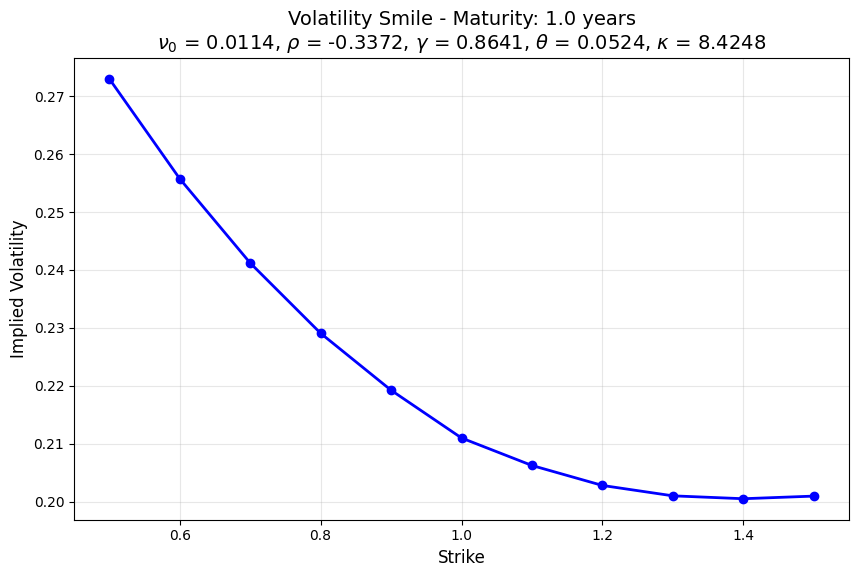

In [13]:
ex_params = xx[2,:]  # Sample Heston parameters
print(cf_Heston(1e-22-1j, 1.0, 0.0, ex_params))
print(ex_params)
ex_strikes = strikes  # Sample strikes
print(ex_strikes)
prices = FFT_CM_Call(ex_strikes, ex_params, 1.0, 0.0, 1.0)
print(prices)
ivs = FFT_CM_Call_IV(ex_strikes, ex_params, 1.0, 0.0, 1.0)
print(ivs)

# Definizione dei nomi dei parametri
param_names = [r'$\nu_0$', r'$\rho$', r'$\gamma$', r'$\theta$', r'$\kappa$']

# Creazione stringa "nome = valore"
params_str = ", ".join([f"{name} = {val:.4f}" for name, val in zip(param_names, ex_params)])

# Plot delle implied volatilities calcolate
plt.figure(figsize=(10, 6))
plt.plot(strikes, ivs, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Strike', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title(f'Volatility Smile - Maturity: {1.0} years\n{params_str}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


Implied Volatilities: [0.27768381 0.25887292 0.24286664 0.22940683 0.21846281 0.20938384
 0.20426641 0.20079574 0.19928562 0.19926131 0.20027823]


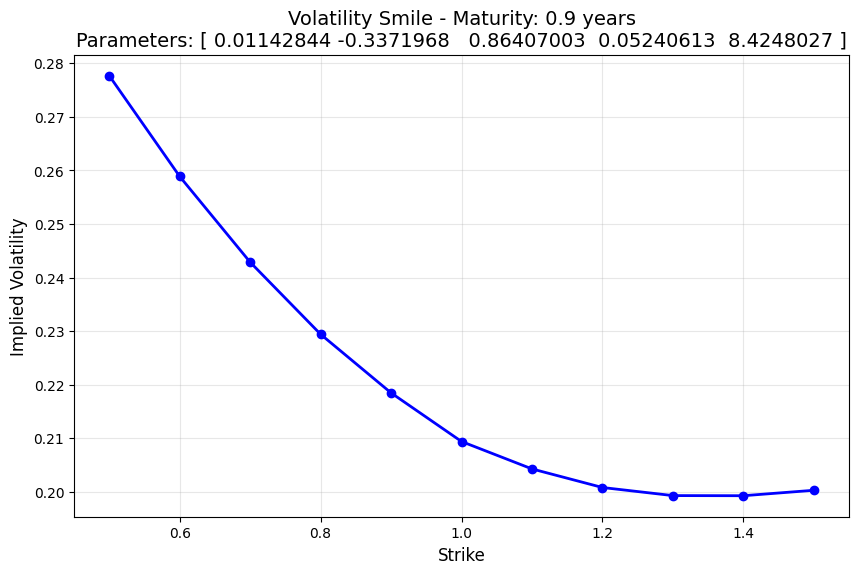

In [9]:
# Example usage:
ex_params = xx[2,:]  # Sample Heston parameters
ex_T = maturities[3]  # Maturity
r = 0.0  # Risk-free rate
S0 = 1.0  # Spot price
ex_strikes = strikes  # Sample strikes

ivs = FFT_CM_Call_IV(ex_strikes, ex_params, ex_T, r, S0)
print("Implied Volatilities:", ivs)

# Plot delle implied volatilities calcolate
plt.figure(figsize=(10, 6))
plt.plot(strikes, ivs, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Strike', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title(f'Volatility Smile - Maturity: {ex_T} years\nParameters: {ex_params}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

Calculating entire volatility surface...


100%|██████████| 7/7 [00:00<00:00, 20.61it/s]


Volatility surface calculation completed!
Shape of yy_calculated: (77,)
Reshaped surface: (7, 11)


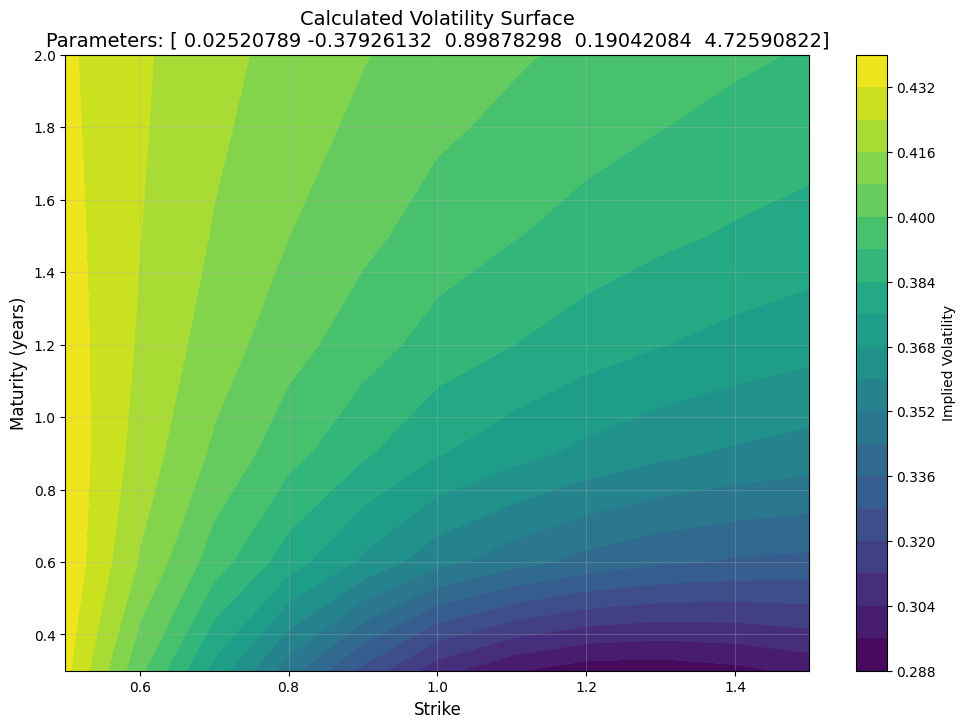

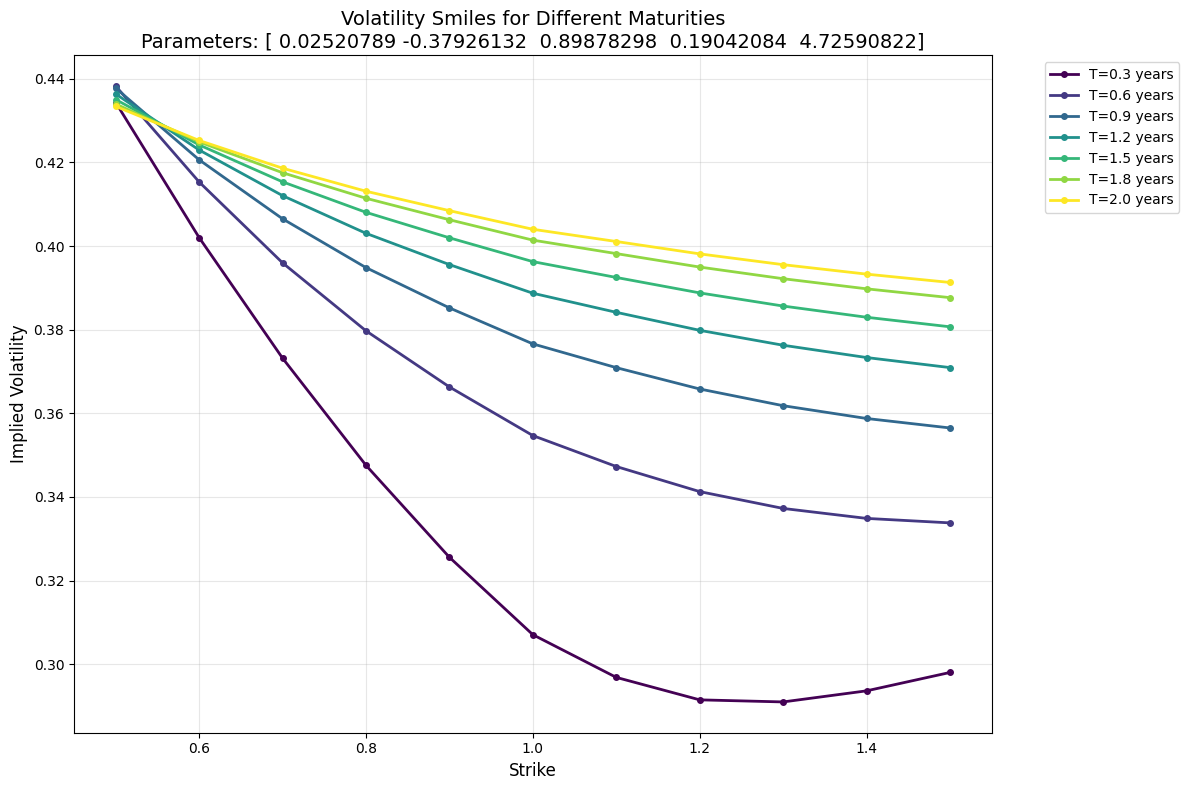

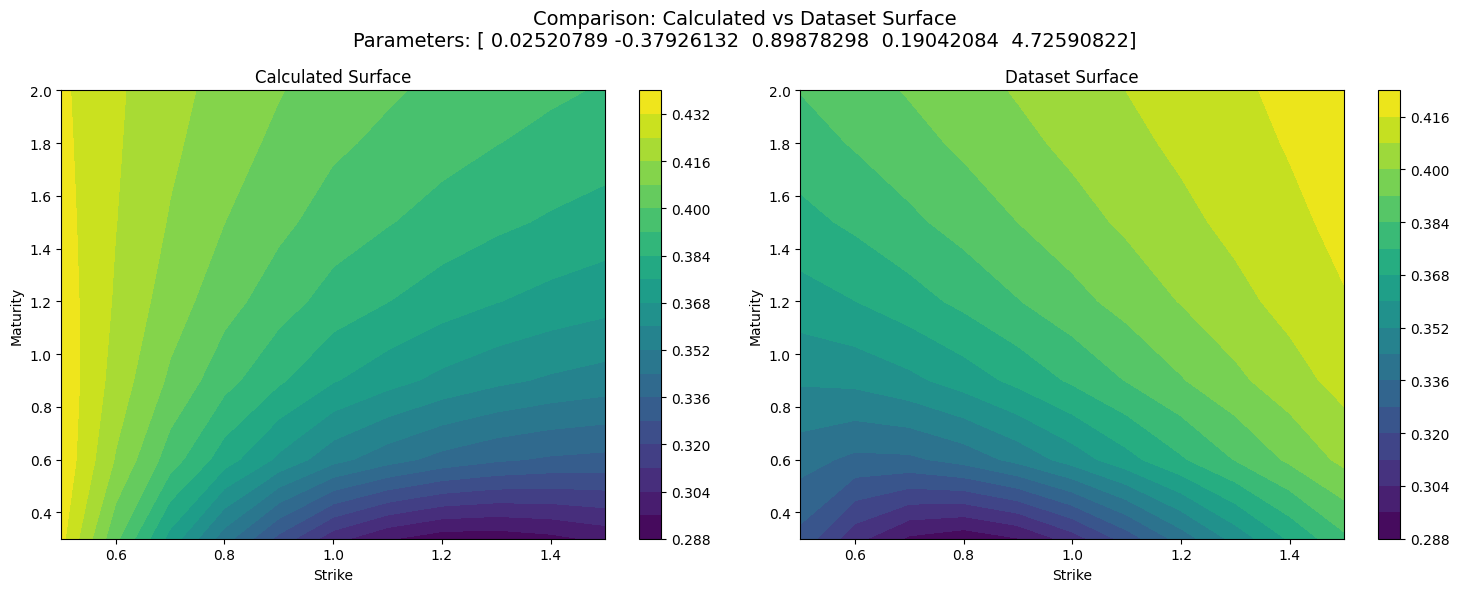


Comparison with dataset:
Maximum absolute difference: 0.108859
Average absolute difference: 0.035578


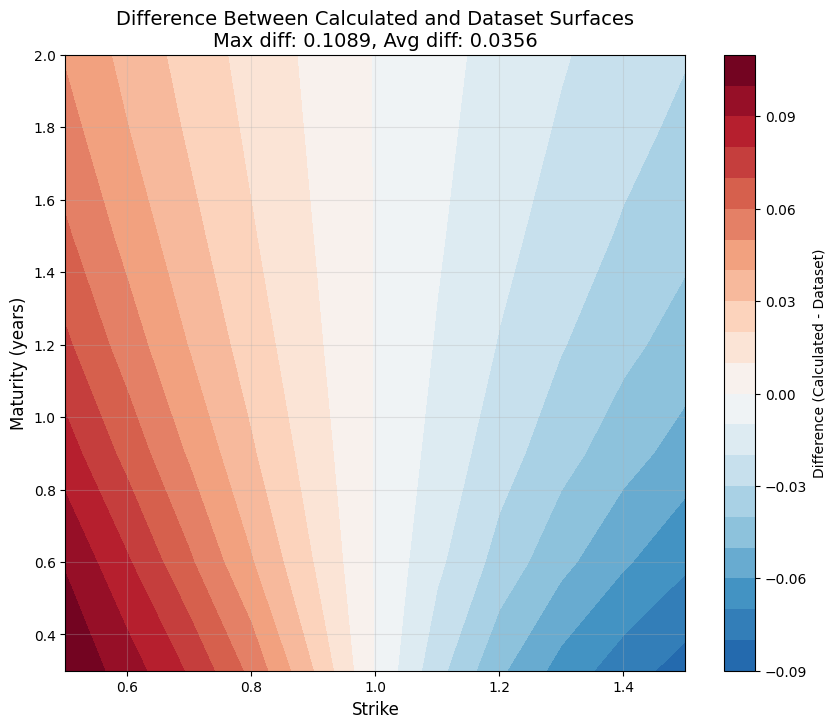


Final yy array (88 values):
[0.43432479 0.40201492 0.3731825  0.347557   0.32556927 0.30706295
 0.29685233 0.29148062 0.29098265 0.29363464 0.29803048 0.43824399
 0.415319   0.39597531 0.37972333 0.36630294 0.35467886 0.34727946
 0.34127969 0.33725464 0.33487269 0.33380028 0.43775741 0.42061648
 0.40650814 0.394839   0.38520772 0.3766039  0.37092235 0.36581953
 0.36182273 0.35876598 0.35650073 0.43636007 0.42296734 0.41204964
 0.40304251 0.3955639  0.3887169  0.38415375 0.37984583 0.37627862
 0.37334007 0.3709361  0.43503846 0.4241808  0.41535543 0.40806228
 0.40196744 0.39627565 0.39248926 0.38879737 0.38565374 0.38297407
 0.38068956 0.43397257 0.42490359 0.41753244 0.41142331 0.40628851
 0.4014135  0.39819347 0.39497684 0.39219217 0.38977226 0.38766306
 0.43339627 0.42524353 0.41861251 0.41310539 0.40846113 0.40400906
 0.40108721 0.39812856 0.39554745 0.39328483 0.39129351]
Shape: (77,)

Verification of structure:
Maturity 0.3 years: indices 0:11
  IVs: [0.43432479 0.40201492 0.3731

In [ ]:
from tqdm import tqdm  # For progress bar

# Define strikes and maturities
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

# Parameters
ex_params = xx[1024, :]  # Sample Heston parameters
r = 0.0  # Risk-free rate
S0 = 1.0  # Spot price

# Initialize the volatility surface array
yy_calculated = np.zeros(len(maturities) * len(strikes))

print("Calculating entire volatility surface...")

# Calculate IVs for each maturity
for i, T in enumerate(tqdm(maturities)):
    # Calculate IVs for all strikes at this maturity
    ivs = FFT_CM_Call_IV(strikes, ex_params, T, r, S0)
    
    # Store in the appropriate position
    start_idx = i * len(strikes)
    end_idx = start_idx + len(strikes)
    yy_calculated[start_idx:end_idx] = ivs

print("Volatility surface calculation completed!")
print(f"Shape of yy_calculated: {yy_calculated.shape}")

# Reshape to see the surface better
yy_surface = yy_calculated.reshape(len(maturities), len(strikes))
print(f"Reshaped surface: {yy_surface.shape}")

# Plot the entire volatility surface
plt.figure(figsize=(12, 8))
X, Y = np.meshgrid(strikes, maturities)
contour = plt.contourf(X, Y, yy_surface, 20, cmap='viridis')
plt.colorbar(contour, label='Implied Volatility')
plt.xlabel('Strike', fontsize=12)
plt.ylabel('Maturity (years)', fontsize=12)
plt.title(f'Calculated Volatility Surface\nParameters: {ex_params}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Plot smiles for different maturities
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(maturities)))

for i, T in enumerate(maturities):
    start_idx = i * len(strikes)
    end_idx = start_idx + len(strikes)
    ivs_maturity = yy_calculated[start_idx:end_idx]
    plt.plot(strikes, ivs_maturity, 'o-', color=colors[i], 
             label=f'T={T} years', linewidth=2, markersize=4)

plt.xlabel('Strike', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title(f'Volatility Smiles for Different Maturities\nParameters: {ex_params}', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare with the original dataset surface
if len(yy) > 1024:  # Make sure we have the dataset
    yy_original = yy[1024, 11:].reshape(len(maturities), len(strikes))
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Calculated surface
    contour1 = axes[0].contourf(X, Y, yy_surface, 20, cmap='viridis')
    axes[0].set_title('Calculated Surface', fontsize=12)
    axes[0].set_xlabel('Strike')
    axes[0].set_ylabel('Maturity')
    plt.colorbar(contour1, ax=axes[0])
    
    # Original dataset surface
    contour2 = axes[1].contourf(X, Y, yy_original, 20, cmap='viridis')
    axes[1].set_title('Dataset Surface', fontsize=12)
    axes[1].set_xlabel('Strike')
    axes[1].set_ylabel('Maturity')
    plt.colorbar(contour2, ax=axes[1])
    
    plt.suptitle(f'Comparison: Calculated vs Dataset Surface\nParameters: {ex_params}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Calculate differences
    differences = yy_surface - yy_original
    max_diff = np.max(np.abs(differences))
    avg_diff = np.mean(np.abs(differences))
    
    print(f"\nComparison with dataset:")
    print(f"Maximum absolute difference: {max_diff:.6f}")
    print(f"Average absolute difference: {avg_diff:.6f}")
    
    # Plot differences
    plt.figure(figsize=(10, 8))
    contour_diff = plt.contourf(X, Y, differences, 20, cmap='RdBu_r', vmin=-max_diff, vmax=max_diff)
    plt.colorbar(contour_diff, label='Difference (Calculated - Dataset)')
    plt.xlabel('Strike', fontsize=12)
    plt.ylabel('Maturity (years)', fontsize=12)
    plt.title(f'Difference Between Calculated and Dataset Surfaces\nMax diff: {max_diff:.4f}, Avg diff: {avg_diff:.4f}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

# Print the final yy array (77 values)
print("\nFinal yy array (77 values):")
print(yy_calculated)
print(f"Shape: {yy_calculated.shape}")

# Verify the structure
print("\nVerification of structure:")
for i, T in enumerate(maturities):
    start_idx = i * len(strikes)
    end_idx = start_idx + len(strikes)
    print(f"Maturity {T} years: indices {start_idx}:{end_idx}")
    print(f"  IVs: {yy_calculated[start_idx:end_idx]}")

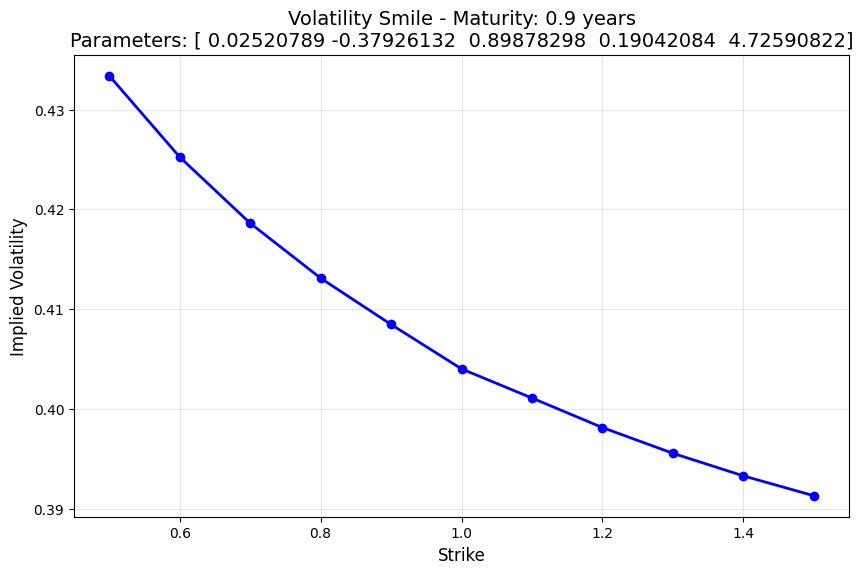

True parameters: [ 0.02520789 -0.37926132  0.89878298  0.19042084  4.72590822]
Market IVs shape: (77,)
Initial guess: [ 0.01471355 -0.38435411  0.48919458  0.16503122  5.3131502 ]
Starting calibration...


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minimize.py:576: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


Current parameters: [ 0.02850124 -0.38483487  0.48984202  0.2         5.31342708], MSE: 0.000470
Current parameters: [ 0.023136   -0.38497416  0.48993359  0.18497154  5.31328755], MSE: 0.000163
Current parameters: [ 0.02313088 -0.38535509  0.49032204  0.1834095   5.31326072], MSE: 0.000159
Current parameters: [ 0.0236892  -0.38584138  0.49082349  0.18303028  5.31323957], MSE: 0.000158
Current parameters: [ 0.03119635 -0.39217841  0.49735301  0.17988044  5.31297163], MSE: 0.000147
Current parameters: [ 0.03693854 -0.39809824  0.50340562  0.17856912  5.31270282], MSE: 0.000141
Current parameters: [ 0.04       -0.41513849  0.5204944   0.17757244  5.3117654 ], MSE: 0.000122
Current parameters: [ 0.04       -0.5257365   0.63117177  0.17677944  5.30548161], MSE: 0.000051
Current parameters: [ 0.04       -0.54010936  0.64579469  0.1798353   5.30459919], MSE: 0.000031
Current parameters: [ 0.03284418 -0.54944229  0.65522937  0.18364331  5.30393206], MSE: 0.000020
Current parameters: [ 0.027964

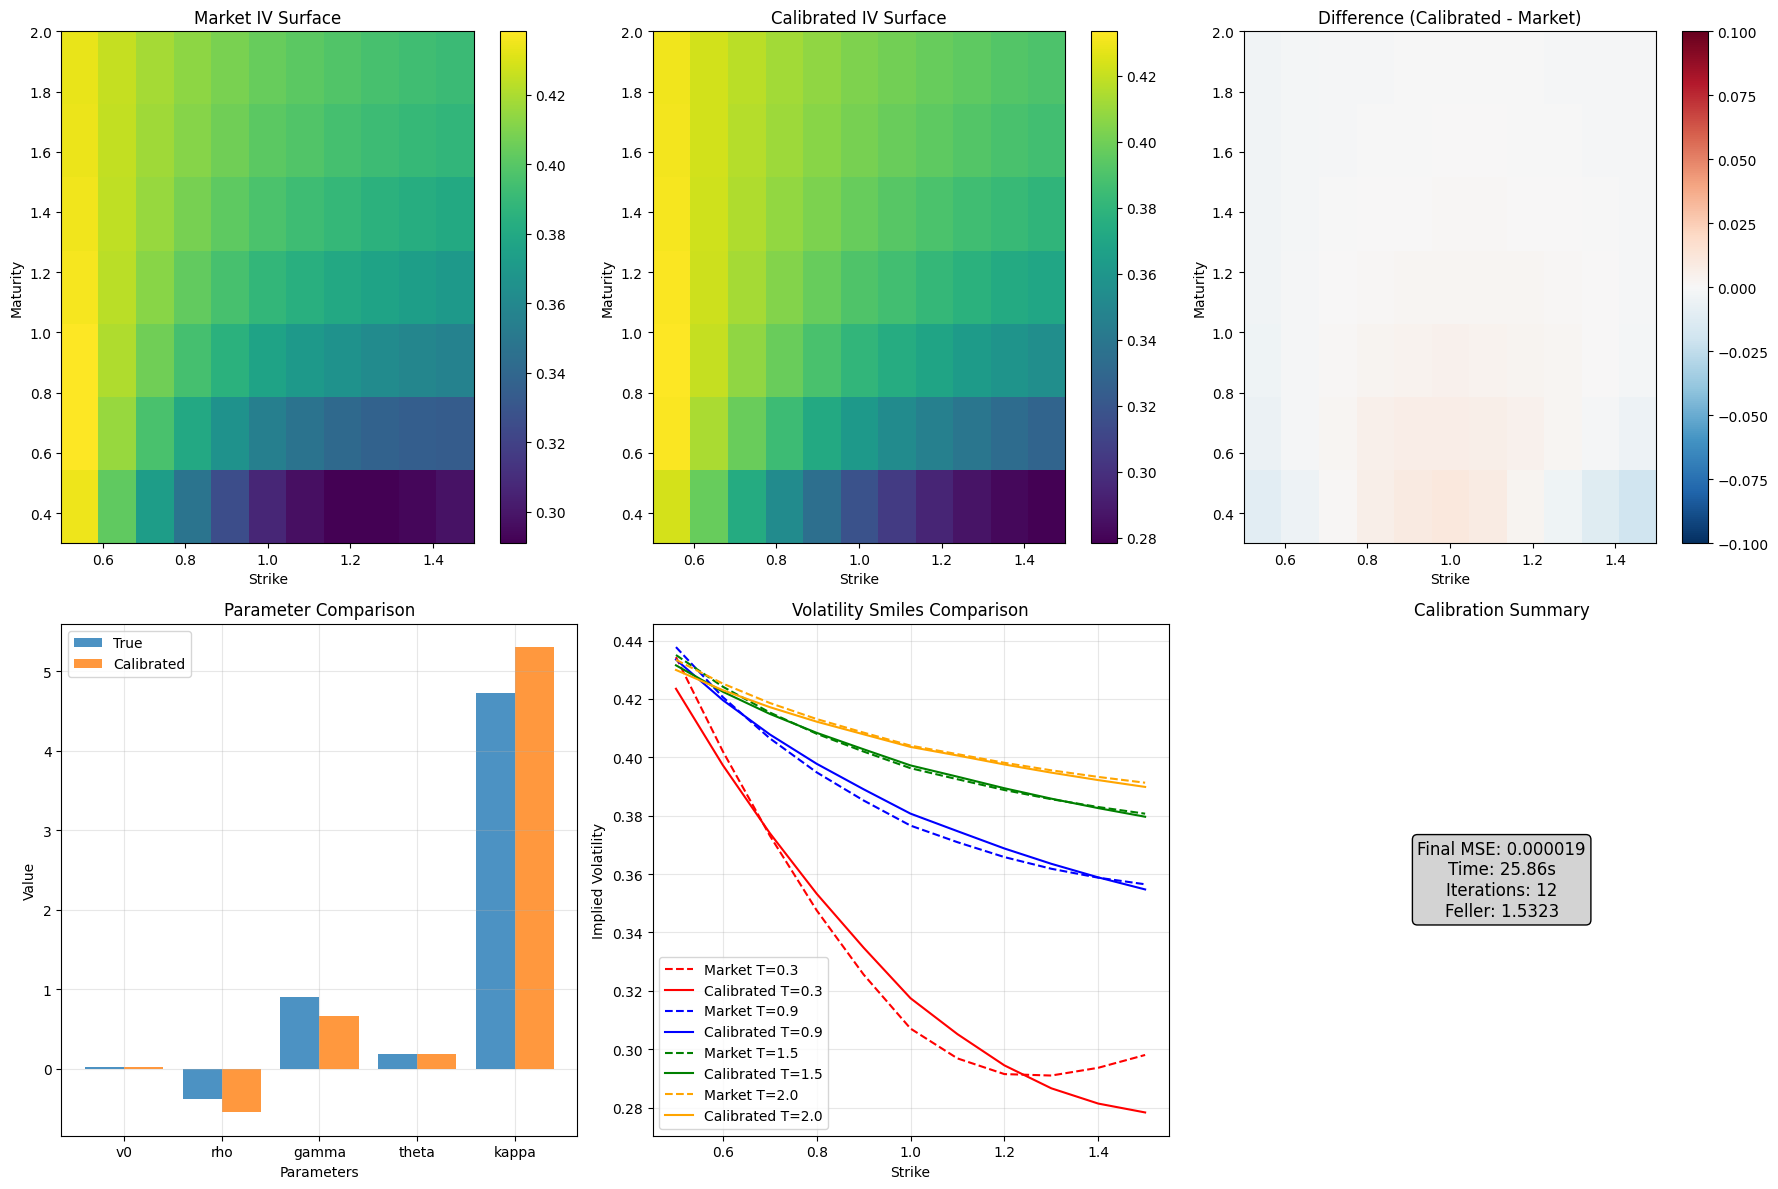


Total calibration time: 25.86 seconds


In [23]:
from scipy.optimize import minimize
import time

# Plot the calculated implied volatilities
plt.figure(figsize=(10, 6))
plt.plot(strikes, ivs, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Strike', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)
plt.title(f'Volatility Smile - Maturity: {ex_T} years\nParameters: {ex_params}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# Objective function for calibration
def objective_function(params, market_ivs, strikes, maturities, r, S0):
    """
    Objective function for calibration: MSE between market IV and model IV
    
    Parameters:
    - params: Heston parameters [ν₀, ρ, γ, θ, κ]
    - market_ivs: Market implied volatility surface (flattened)
    - strikes: Array of strikes
    - maturities: Array of maturities
    - r: Risk-free rate
    - S0: Spot price
    
    Returns:
    - MSE between market IV and model IV
    """
    total_mse = 0.0
    count = 0
    
    # Reconstruct surface from flattened IVs
    market_iv_surface = market_ivs.reshape(len(maturities), len(strikes))
    
    for i, T in enumerate(maturities):
        try:
            # Calculate model IV for this maturity
            model_ivs = FFT_CM_Call_IV(strikes, params, T, r, S0)
            
            # Calculate MSE for this maturity
            mse = np.mean((model_ivs - market_iv_surface[i])**2)
            total_mse += mse
            count += 1
            
        except Exception as e:
            # If pricing fails, return very high MSE
            print(f"Pricing error for T={T}: {e}")
            return 1e10
    
    return total_mse / count if count > 0 else 1e10

# Function to generate random initial guess within specified bounds
def generate_random_initial_guess():
    """
    Generate random initial guess within specified bounds
    """
    v0 = np.random.uniform(0.0001, 0.04)
    rho = np.random.uniform(-0.95, -0.1)
    gamma = np.random.uniform(0.01, 1.0)
    theta = np.random.uniform(0.01, 0.2)
    kappa = np.random.uniform(1.0, 10.0)
    
    return np.array([v0, rho, gamma, theta, kappa])

# Callback function to monitor optimization progress
def callback_function(xk):
    """
    Callback function to monitor optimization progress
    """
    current_mse = objective_function(xk, market_ivs_target, strikes, maturities, r, S0)
    print(f"Current parameters: {xk}, MSE: {current_mse:.6f}")

# Parameters for calibration
r = 0.0  # Risk-free rate
S0 = 1.0  # Spot price

# Use a parameter set 
true_params = xx[1024, :]
market_ivs_target = yy_calculated  # volatility surface

print("True parameters:", true_params)
print("Market IVs shape:", market_ivs_target.shape)

# Generate random initial guess
initial_guess = generate_random_initial_guess()
print("Initial guess:", initial_guess)

# Define bounds for optimization
bounds = [
    (0.0001, 0.04),    # v0
    (-0.95, -0.1),     # rho
    (0.01, 1.0),       # gamma
    (0.01, 0.2),       # theta
    (1.0, 10.0)        # kappa
]

# Additional constraint: Feller condition (2*kappa*theta > gamma^2)
def feller_constraint(params):
    """
    Feller condition constraint: 2*kappa*theta > gamma^2
    Returns positive value if constraint is satisfied
    """
    kappa, theta, gamma = params[4], params[3], params[2]
    return 2 * kappa * theta - gamma**2

constraints = [
    {'type': 'ineq', 'fun': feller_constraint}  # Feller condition
]

# Optimization options
options = {
    'maxiter': 100,
    'disp': True,
    'gtol': 1e-6,
    'ftol': 1e-6
}

# Perform calibration
print("Starting calibration...")
start_time = time.time()

result = minimize(
    objective_function,
    initial_guess,
    args=(market_ivs_target, strikes, maturities, r, S0),
    method='L-BFGS-B',
    bounds=bounds,
    constraints=constraints,
    options=options,
    callback=callback_function
)

end_time = time.time()
calibration_time = end_time - start_time

# Print detailed calibration results
print("\n--- Calibration Results ---")
print(f"Calibration time: {calibration_time:.2f} seconds")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
print(f"Number of iterations: {result.nit}")
print(f"Number of function evaluations: {result.nfev}")

print(f"\nParameter comparison:")
print("Parameter    True Value    Calibrated Value    Difference    % Error")
print("-" * 75)

param_names = ['v0', 'rho', 'gamma', 'theta', 'kappa']
for i, name in enumerate(param_names):
    true_val = true_params[i]
    calib_val = result.x[i]
    diff = calib_val - true_val
    pct_error = (diff / true_val) * 100 if true_val != 0 else 0
    print(f"{name:8} {true_val:12.6f} {calib_val:16.6f} {diff:12.6f} {pct_error:10.2f}%")

print(f"\nFinal MSE: {result.fun:.8f}")

# Check Feller condition
feller_value = 2 * result.x[4] * result.x[3] - result.x[2]**2
print(f"Feller condition (2*kappa*theta - gamma^2): {feller_value:.6f}")
print(f"Feller condition satisfied: {feller_value > 0}")

# Function to plot calibration results
def plot_calibration_results(true_params, calibrated_params, market_ivs, strikes, maturities, r, S0):
    """
    Plot calibration results with comparison between true and calibrated parameters
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Market surface
    market_surface = market_ivs.reshape(len(maturities), len(strikes))
    im1 = axes[0, 0].imshow(market_surface, aspect='auto', origin='lower',
                          extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()])
    axes[0, 0].set_title('Market IV Surface')
    axes[0, 0].set_xlabel('Strike')
    axes[0, 0].set_ylabel('Maturity')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Calibrated surface
    calibrated_ivs = []
    for T in maturities:
        ivs_calib = FFT_CM_Call_IV(strikes, calibrated_params, T, r, S0)
        calibrated_ivs.append(ivs_calib)
    calibrated_surface = np.array(calibrated_ivs)
    
    im2 = axes[0, 1].imshow(calibrated_surface, aspect='auto', origin='lower',
                          extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()])
    axes[0, 1].set_title('Calibrated IV Surface')
    axes[0, 1].set_xlabel('Strike')
    axes[0, 1].set_ylabel('Maturity')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # Difference between surfaces
    diff_surface = calibrated_surface - market_surface
    im3 = axes[0, 2].imshow(diff_surface, aspect='auto', origin='lower',
                          extent=[strikes.min(), strikes.max(), maturities.min(), maturities.max()],
                          cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    axes[0, 2].set_title('Difference (Calibrated - Market)')
    axes[0, 2].set_xlabel('Strike')
    axes[0, 2].set_ylabel('Maturity')
    plt.colorbar(im3, ax=axes[0, 2])
    
    # Parameter comparison bar chart
    param_names = ['v0', 'rho', 'gamma', 'theta', 'kappa']
    x_pos = np.arange(len(param_names))
    
    axes[1, 0].bar(x_pos - 0.2, true_params, width=0.4, label='True', alpha=0.8)
    axes[1, 0].bar(x_pos + 0.2, result.x, width=0.4, label='Calibrated', alpha=0.8)
    axes[1, 0].set_xlabel('Parameters')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].set_title('Parameter Comparison')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(param_names)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Volatility smiles for selected maturities
    selected_maturities = [0, 2, 4, 6]  # Select some maturities
    colors = ['red', 'blue', 'green', 'orange']
    
    for i, mat_idx in enumerate(selected_maturities):
        T = maturities[mat_idx]
        axes[1, 1].plot(strikes, market_surface[mat_idx], 
                       color=colors[i], linestyle='--', label=f'Market T={T}')
        axes[1, 1].plot(strikes, calibrated_surface[mat_idx], 
                       color=colors[i], linestyle='-', label=f'Calibrated T={T}')
    
    axes[1, 1].set_title('Volatility Smiles Comparison')
    axes[1, 1].set_xlabel('Strike')
    axes[1, 1].set_ylabel('Implied Volatility')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # MSE evolution (simplified - would need to store during optimization)
    axes[1, 2].text(0.5, 0.5, f'Final MSE: {result.fun:.6f}\n'
                    f'Time: {calibration_time:.2f}s\n'
                    f'Iterations: {result.nit}\n'
                    f'Feller: {feller_value:.4f}',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=axes[1, 2].transAxes,
                    fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1, 2].set_title('Calibration Summary')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot calibration results
plot_calibration_results(true_params, result.x, market_ivs_target, strikes, maturities, r, S0)

print(f"\nTotal calibration time: {calibration_time:.2f} seconds")